In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import math, operator

import warnings
warnings.filterwarnings('ignore')

# визуализация процесса apply
from tqdm import tqdm
tqdm.pandas()

from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard
from keras_tqdm import TQDMNotebookCallback

seed = 48
np.random.seed(seed) # фиксируем seed

Using TensorFlow backend.


In [2]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [3]:
series = pd.read_csv('pollution.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

In [4]:
series["unix_timestamp"] = series.index.astype(np.int64) // 10**9

In [5]:
series.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain', 'unix_timestamp'],
      dtype='object')

In [6]:
df = series[["pollution","rain","snow"]]
df = (df - df.min()) / (df.max() - df.min())

In [7]:
df[df.index>"2014-05-01"].plot(figsize=(20,10))

In [8]:
df = series[["pollution","temp","press"]]
df = (df - df.min()) / (df.max() - df.min())

In [9]:
df[df.index>"2014-05-01"].plot(figsize=(20,10))

In [10]:
df = series[["pollution","wnd_spd"]]
df = (df - df.min()) / (df.max() - df.min())

In [11]:
df[df.index>"2014-05-01"].plot(figsize=(20,10))

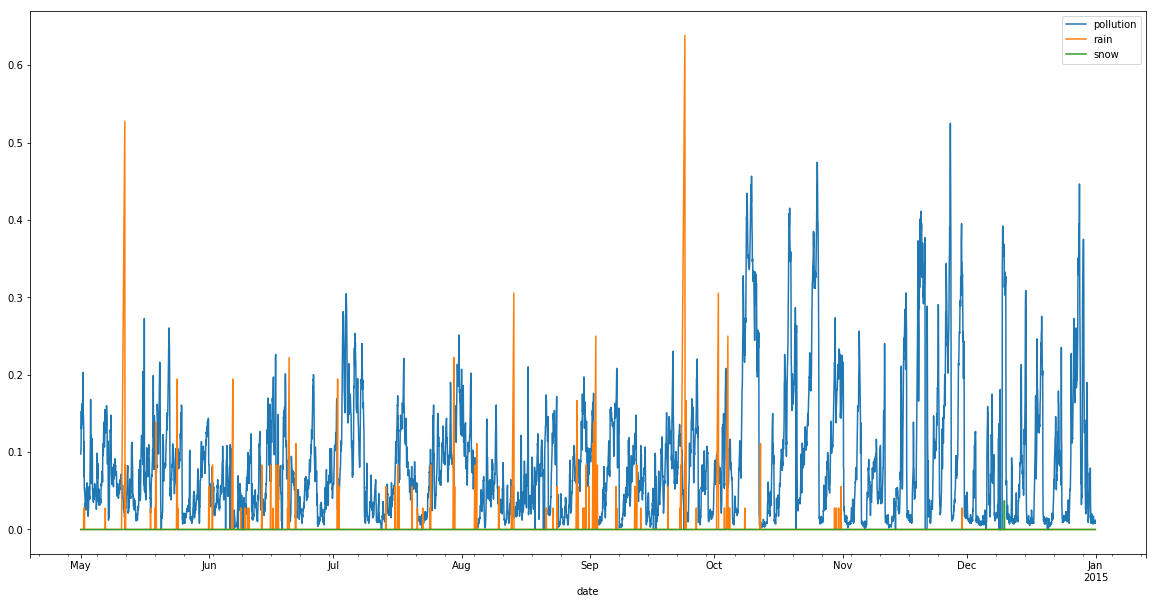

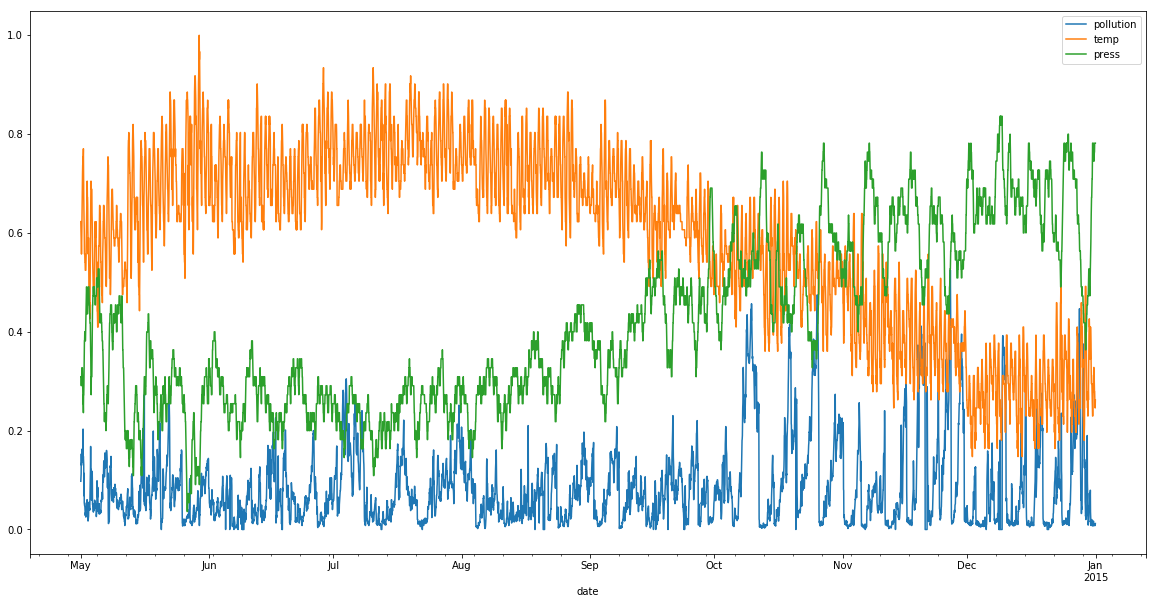

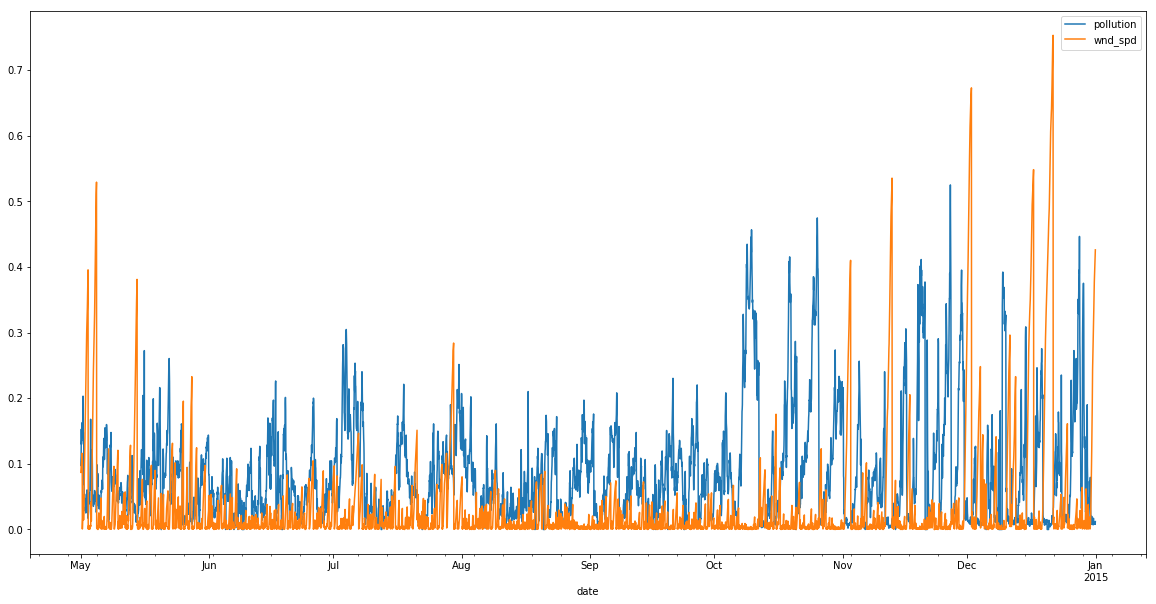

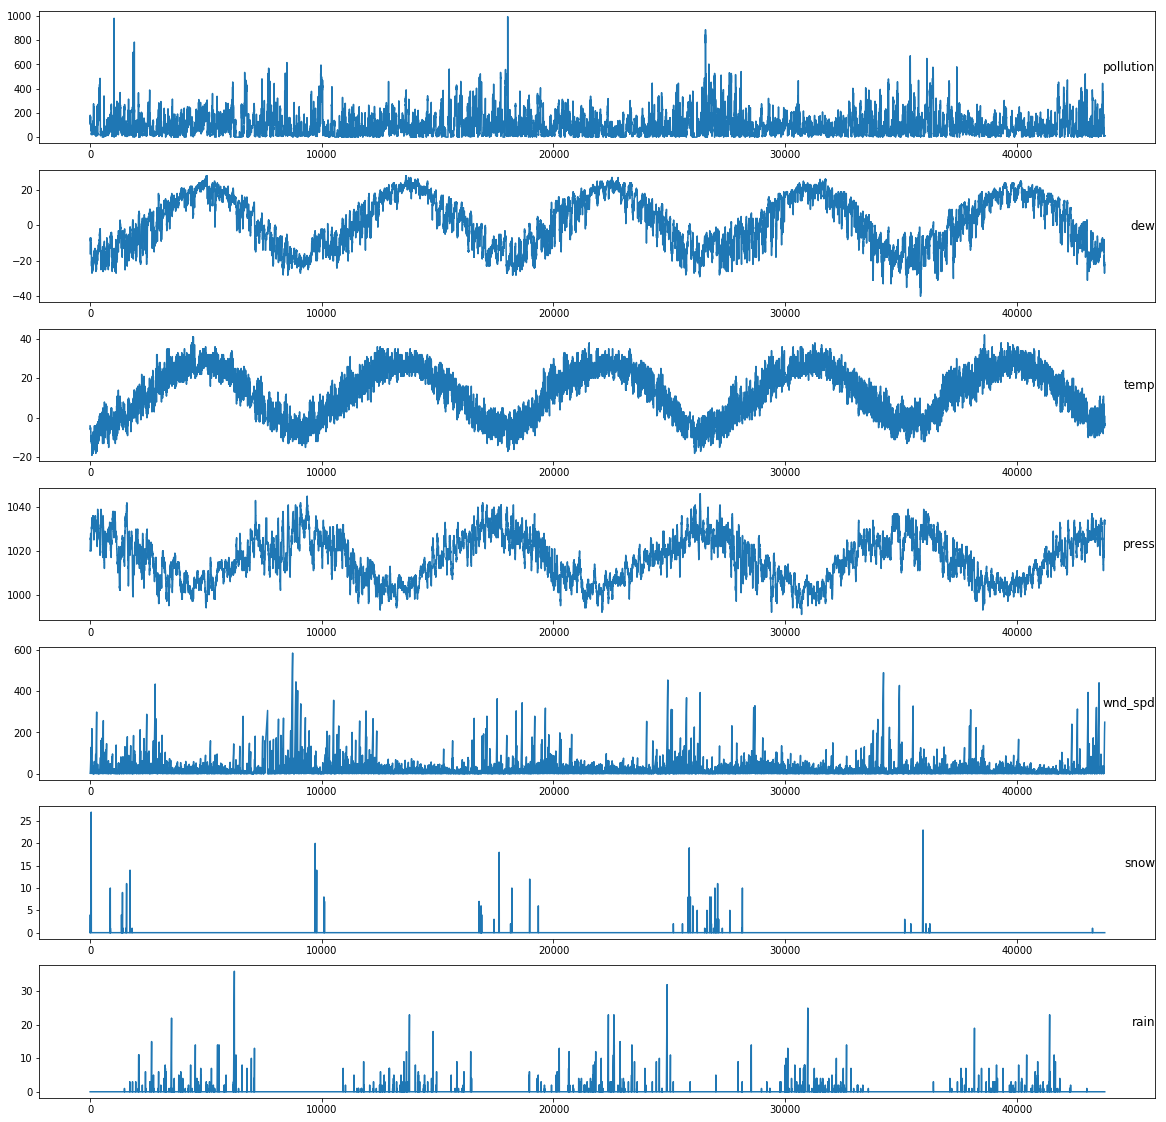

In [12]:
# load dataset
values = series.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(20,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(series.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

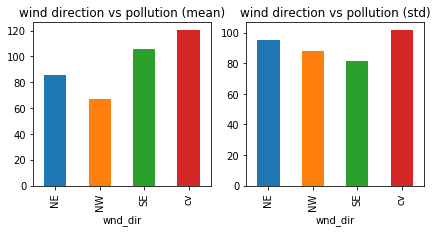

In [13]:
data = series
f,ax=plt.subplots(1,2,figsize=(7,3))

data.groupby(['wnd_dir'])['pollution'].mean().plot.bar(ax=ax[0])
ax[0].set_title('wind direction vs pollution (mean)')

data.groupby(['wnd_dir'])['pollution'].std().plot.bar(ax=ax[1])
ax[1].set_title('wind direction vs pollution (std)')

plt.show()

### Feature Engineering

In [14]:
from tsfresh.feature_extraction.feature_calculators import absolute_sum_of_changes, mean_change

In [15]:
window1 = int(5)
features=["wnd_spd","temp"]
feature_name = "_mean_change"

add_feat = series[features].rolling(window1).progress_apply(mean_change).reset_index()
add_feat.columns = ["date"]+[c+feature_name + "_window" + str(window1) for c in features]
add_feat=add_feat.set_index(["date"],drop=True)
series = series.merge(add_feat, left_index=True, right_index=True, how="left")

87592it [00:01, 75363.96it/s]


In [16]:
# convert time series into supervised learning problem
def series_to_supervised(data, features, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols1, cols2, names1, names2 = list(), list(), list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols1.append(df.shift(i))
        names1 += [(features[j]+'(t-%d)' % i) for j in range(n_vars)]
        cols2.append(df.shift(1).diff(i))
        names2 += [(features[j]+'_d(t-%d)' % i) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols1.append(df.shift(-i))
        cols2.append(df.diff(-i))
        if i == 0:
            names1 += [(features[j]+'(t+0)') for j in range(n_vars)]
            names2 += [(features[j]+'_d(t+0)') for j in range(n_vars)]
        else:
            names1 += [(features[j]+'(t+%d)' % i) for j in range(n_vars)]
            names2 += [(features[j]+'_d(t+%d)' % i) for j in range(n_vars)]
    # put it all together
    agg1 = pd.concat(cols1, axis=1)
    agg1.columns = names1
    agg2 = pd.concat(cols2, axis=1)
    agg2.columns = names2
    agg = pd.concat([agg1,agg2],axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Additional preprocessing

1. Category features encoding by using Target encoding (month, weekday, hour)

2. Make stationary time series from features and target. Differeces and Box-Cox transform for variance

In [17]:
# transform series into train and test sets for supervised learning
def preprocessing_data(series, cols_to_drop, target, n_train, n_lag, n_seq):
    # extract raw values
    series = series.dropna(how="any", axis=0)
    series = series.drop(cols_to_drop, axis=1)

    max_window=5
    train, test = series[0:n_train], series[n_train+max_window:]
    # you can add validation part too
    # series[n_train+largest_window:], prevent overfitting to nearest points to train

    train_y = train[target]
    train_x = train.drop(target, axis=1)
    train_time = pd.DataFrame(train.index)
    test_y = test[target]
    test_x = test.drop(target, axis=1)
    test_time = pd.DataFrame(test.index)

    features = train_x.columns
    cat_features=["wnd_dir"] # to be label encoded

    encoder = LabelEncoder()
    train_x[cat_features] = encoder.fit_transform(train_x[cat_features])
    test_x[cat_features] = encoder.transform(test_x[cat_features])

    scaler_x = MinMaxScaler(feature_range=(0,1))
    train_x = scaler_x.fit_transform(train_x)
    test_x = scaler_x.transform(test_x)

    scaler_y = MinMaxScaler(feature_range=(0,1))
    train_y = scaler_y.fit_transform(train_y)
    test_y = scaler_y.transform(test_y)

    train_x = series_to_supervised(train_x, features, n_lag, n_for)
    test_x = series_to_supervised(test_x, features, n_lag, n_for)
    train_time = series_to_supervised(train_time, ["date"], n_lag, n_for)
    train_y = series_to_supervised(train_y, target, n_lag, n_for)
    test_y = series_to_supervised(test_y, target, n_lag, n_for)
    test_time = series_to_supervised(test_time, ["date"], n_lag, n_for)

    searchfor = ["(t\+"+str(i)+")" for i in range(0,n_for)]+["_d(t\+"+str(i)+")" for i in range(0,n_for)]
    features_x = ~train_x.columns.str.contains('|'.join(searchfor))
    target_cols = [target[0]+"(t+"+str(i)+")" for i in range(0,n_for)]
    lag_cols = [target[0]+"(t-"+str(i)+")" for i in range(1,n_lag+1)]
    dif_cols = [target[0]+"_d(t-"+str(i)+")" for i in range(1,n_lag+1)]

    train_Y = train_y[target_cols]
    test_Y = test_y[target_cols]

    train_X = pd.concat([train_x.loc[:,features_x], train_y[lag_cols+dif_cols]], axis=1)
    test_X = pd.concat([test_x.loc[:,features_x], test_y[lag_cols+dif_cols]], axis=1)
    
    return scaler_y, train_X, train_Y, test_X, test_Y, train_time, test_time

In [18]:
# configure
n_lag=5
n_features=10
n_for=3
n_train=2*365*24 # 2 years in train
n_obs=n_lag*n_features

# prepare data
cols_to_drop=["unix_timestamp"]
target=["pollution"]

scaler_y, train_X, train_Y, test_X, test_Y, train_time, test_time = preprocessing_data(series, cols_to_drop, target, 
                                                                                       n_train, n_lag, n_for)

### Feature Selection

In [19]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [20]:
rfc = RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1, max_features=0.2, random_state=17)

boruta_selector = BorutaPy(rfc, max_iter=100, n_estimators='auto', verbose=2)
boruta_selector.fit(train_X.values, train_Y['pollution(t+2)'].values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	23
Tentative: 	35
Rejected: 	42
Iteration: 	9 / 100
Confirmed: 	23
Tentative: 	35
Rejected: 	42
Iteration: 	10 / 100
Confirmed: 	23
Tentative: 	35
Rejected: 	42
Iteration: 	11 / 100
Confirmed: 	23
Tentative: 	35
Rejected: 	42
Iteration: 	12 / 100
Confirmed: 	27
Tentative: 	26
Rejected: 	47
Iteration: 	13 / 100
Confirmed: 	27
Tentative: 	26
Rejected: 	47
Iteration: 	14 / 100
Confirmed: 	27
Tentative: 	26
Rejected: 	47
Iteration: 	15 / 100
Confirmed: 	27
Tentative: 	26
Rejected: 	47
Iteration: 	16 / 100
Confirmed: 	27
Tenta

BorutaPy(alpha=0.05,
     estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=193, n_jobs=-1,
           oob_score=False,
           random_state=<mtrand.RandomState object at 0x10c6457e0>,
           verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x10c6457e0>,
     two_step=True, verbose=2)

In [21]:
# number of selected features
print ('\n Number of selected features:')
print (boruta_selector.n_features_)

feature_df = pd.DataFrame(train_X.columns, columns=['features'])
feature_df['rank']=pd.Series(boruta_selector.ranking_)
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
print (feature_df.head(boruta_selector.n_features_))

# check ranking of features
print ('\n Feature ranking:')
print (boruta_selector.ranking_)


 Number of selected features:
33

 Top 33 features:
                            features  rank
0                     wnd_spd_d(t-5)     1
1                           dew(t-1)     1
2                          temp(t-1)     1
3                       wnd_dir(t-1)     1
4                       wnd_spd(t-1)     1
5   wnd_spd_mean_change_window5(t-1)     1
6                         dew_d(t-5)     1
7                   pollution_d(t-4)     1
8    temp_mean_change_window5_d(t-5)     1
9                         dew_d(t-4)     1
10                    wnd_spd_d(t-4)     1
11   temp_mean_change_window5_d(t-4)     1
12                        dew_d(t-3)     1
13                    wnd_spd_d(t-3)     1
14   temp_mean_change_window5_d(t-3)     1
15                        dew_d(t-2)     1
16                    wnd_spd_d(t-2)     1
17                    wnd_spd_d(t-1)     1
18                    pollution(t-1)     1
19                    pollution(t-2)     1
20                    pollution(t-3)     1
2

In [22]:
selected_boruta = list(feature_df[feature_df["rank"] == 1]["features"])

In [23]:
train_X[selected_boruta].head()

,wnd_spd_d(t-5),dew(t-1),temp(t-1),wnd_dir(t-1),wnd_spd(t-1),wnd_spd_mean_change_window5(t-1),dew_d(t-5),pollution_d(t-4),temp_mean_change_window5_d(t-5),dew_d(t-4),...,pollution_d(t-1),pollution_d(t-2),pollution_d(t-3),wnd_dir(t-2),temp(t-2),pollution_d(t-5),wnd_dir(t-5),dew(t-2),wnd_dir(t-3),wnd_dir(t-4)
6,0.013757,0.375000,0.233333,0.666667,0.023669,0.908025,0.000000,0.023469,0.064516,0.000000,...,0.012245,0.008163,0.027551,0.666667,0.216667,-0.006122,0.666667,0.357143,0.666667,0.666667
7,0.017585,0.375000,0.233333,0.666667,0.029018,0.910114,0.000000,0.035714,0.096774,0.000000,...,0.008163,0.020408,0.016327,0.666667,0.233333,0.031633,0.666667,0.375000,0.666667,0.666667
8,0.019875,0.357143,0.233333,0.666667,0.034367,0.912203,-0.017857,0.028571,0.032258,-0.017857,...,0.012245,0.020408,0.032653,0.666667,0.233333,0.047959,0.666667,0.375000,0.666667,0.666667
9,0.022165,0.357143,0.233333,0.666667,0.039716,0.914292,-0.017857,0.028571,0.032258,0.000000,...,-0.004082,0.008163,0.016327,0.666667,0.233333,0.024490,0.666667,0.357143,0.666667,0.666667
10,0.025976,0.357143,0.233333,0.666667,0.046586,0.917768,0.000000,0.032653,0.032258,-0.017857,...,0.016327,0.012245,0.024490,0.666667,0.233333,0.044898,0.666667,0.357143,0.666667,0.666667


In [24]:
train_X = train_X[selected_boruta]
test_X = test_X[selected_boruta]

In [25]:
#train_X = train_X.as_matrix().reshape((train_X.shape[0], n_lag, n_features))
#test_X = test_X.as_matrix().reshape((test_X.shape[0], n_lag, n_features))

#train_Y = train_Y.as_matrix().reshape((train_Y.shape[0], train_Y.shape[1]))
#test_Y = test_Y.as_matrix().reshape((test_Y.shape[0], test_Y.shape[1]))

### Correlations

In [26]:
def CorrelationSelector(X,y):
    columns = X.columns
    corr_data = dict([(abs(np.corrcoef(X[c],y)[0,1]),c) for c in columns if math.isnan(abs(np.corrcoef(X[c],y)[0,1]))==False])
    sorted_corr_data = sorted(corr_data.items(), key=operator.itemgetter(0), reverse=True)
    return sorted_corr_data

In [27]:
CorrelationSelector(train_X,train_Y.iloc[:,2])

[(0.8615770473722467, 'pollution(t-1)'),
 (0.8168322148620955, 'pollution(t-2)'),
 (0.7749510715030709, 'pollution(t-3)'),
 (0.7362788795990101, 'pollution(t-4)'),
 (0.7003912575071317, 'pollution(t-5)'),
 (0.28936656143183875, 'pollution_d(t-5)'),
 (0.2663108719452044, 'pollution_d(t-4)'),
 (0.2603457986001339, 'wnd_dir(t-2)'),
 (0.26011573752867734, 'wnd_dir(t-3)'),
 (0.25720963274778635, 'wnd_dir(t-4)'),
 (0.256646243909564, 'wnd_dir(t-5)'),
 (0.25099798381846117, 'wnd_dir(t-1)'),
 (0.23956318700279816, 'wnd_spd(t-1)'),
 (0.23814299479504852, 'pollution_d(t-3)'),
 (0.23355019324831142, 'dew(t-1)'),
 (0.22705296646704629, 'dew(t-2)'),
 (0.20133816038855026, 'pollution_d(t-2)'),
 (0.1701717770849351, 'dew_d(t-5)'),
 (0.15321506750089436, 'dew_d(t-4)'),
 (0.14304659763082664, 'pollution_d(t-1)'),
 (0.1329928859873929, 'dew_d(t-3)'),
 (0.10787516202097264, 'dew_d(t-2)'),
 (0.06585909873585466, 'temp_mean_change_window5_d(t-5)'),
 (0.04981970675659332, 'temp_mean_change_window5_d(t-4)'),

In [28]:
train_X['pollution(t-3)'].plot(c="red")
train_Y['pollution(t+2)'].plot()
plt.xlim([0,100])
plt.ylim([0,0.2])
plt.legend(['(t-3)','(t+2)'])

### Deep Learning models

### Multilayer perceptron

In [29]:
import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import regularizers

In [30]:
output_file_name='Model_ANN_relu'

batch_size=72
epochs=50
output_size=3

In [31]:
callbacks=[CSVLogger(output_file_name+'.csv', append=True),
                     ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5',
                                     monitor='val_loss', verbose=1,mode='min')]
#EarlyStoppingByLossVal(monitor='val_loss', value=7.93, verbose=1)
#TQDMNotebookCallback()

In [32]:
# 64 x 32 x 8, lambda = 0.01, he_uniform
    #kernel_initializer='he_uniform' больше подходит для функции активации ReLu
    # create model
model = Sequential()
model.add(Dense(64, input_shape=(33,), kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(8, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(output_size, kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('linear'))
    
model.compile(loss='mae', metrics=['mae'],
                  optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [33]:
history = model.fit(train_X.values, train_Y.values,
          batch_size=batch_size,
          validation_data=(train_X.values, train_Y.values),
          epochs = epochs,
          callbacks=callbacks,
                    shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 17512 samples, validate on 17512 samples
Epoch 1/50
17512/17512 [==============================] - 1s 57us/step - loss: 1.0863 - mean_absolute_error: 0.0564 - val_loss: 0.4810 - val_mean_absolute_error: 0.0792
Epoch 2/50
17512/17512 [==============================] - 1s 35us/step - loss: 0.2526 - mean_absolute_error: 0.0415 - val_loss: 0.1870 - val_mean_absolute_error: 0.0786
Epoch 3/50
17512/17512 [==============================] - 1s 35us/step - loss: 0.1110 - mean_absolute_error: 0.0363 - val_loss: 0.1353 - val_mean_absolute_error: 0.0765
Epoch 4/50
17512/17512 [==============================] - 1s 35us/step - loss: 0.0817 - mean_absolute_error: 0.0328 - val_loss: 0.1206 - val_mean_absolute_error: 0.0742
Epoch 5/50
17512/17512 [==============================] - 1s 34us/step - loss: 0.0716 - mean_absolute_error: 0.0308 - val_loss: 0.1128 - val_mean_absolute_error: 0.0715
Epoch 6/50
17512/17512 [==============================] -

Epoch 25/50
17512/17512 [==============================] - 1s 45us/step - loss: 0.0587 - mean_absolute_error: 0.0266 - val_loss: 0.0863 - val_mean_absolute_error: 0.0518
Epoch 26/50
17512/17512 [==============================] - 1s 48us/step - loss: 0.0587 - mean_absolute_error: 0.0266 - val_loss: 0.0864 - val_mean_absolute_error: 0.0520
Epoch 27/50
17512/17512 [==============================] - 1s 43us/step - loss: 0.0587 - mean_absolute_error: 0.0267 - val_loss: 0.0865 - val_mean_absolute_error: 0.0520
Epoch 28/50
17512/17512 [==============================] - 1s 40us/step - loss: 0.0587 - mean_absolute_error: 0.0267 - val_loss: 0.0869 - val_mean_absolute_error: 0.0524
Epoch 29/50
17512/17512 [==============================] - 1s 47us/step - loss: 0.0587 - mean_absolute_error: 0.0267 - val_loss: 0.0870 - val_mean_absolute_error: 0.0526
Epoch 30/50
17512/17512 [==============================] - 1s 41us/step - loss: 0.0587 - mean_absolute_error: 0.0267 - val_loss: 0.0873 - val_mean_abs

17512/17512 [==============================] - 1s 29us/step - loss: 0.0587 - mean_absolute_error: 0.0267 - val_loss: 0.0916 - val_mean_absolute_error: 0.0572
Epoch 50/50
17512/17512 [==============================] - 1s 30us/step - loss: 0.0587 - mean_absolute_error: 0.0267 - val_loss: 0.0919 - val_mean_absolute_error: 0.0574


In [34]:
# loss и MAE различаются

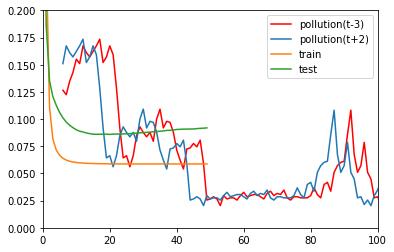

In [35]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
#plt.ylim([0.01,0.05])
plt.legend()
plt.show()

In [36]:
y_pred = model.predict(test_X.values)
y_pred1 = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))

inv_y_pred = scaler_y.inverse_transform(y_pred1)
y_pred = pd.DataFrame(inv_y_pred, columns=["pred(t+1)","pred(t+2)","pred(t+3)"])

y_fact = test_Y.values.reshape((len(test_Y), n_for))
inv_y_fact = scaler_y.inverse_transform(y_fact)
y_fact = pd.DataFrame(inv_y_fact, columns=["fact(t+1)","fact(t+2)","fact(t+3)"])

In [37]:
for i in range(0,n_for):
    rmse=np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_fact.iloc[:,i]))
    r2=r2_score(y_pred.iloc[:,i], y_fact.iloc[:,i])
    print('Test RMSE: %.3f' % rmse, 'Test R2: %.3f' % r2)

Test RMSE: 71.678 Test R2: 0.410
Test RMSE: 72.795 Test R2: 0.350
Test RMSE: 73.755 Test R2: 0.273


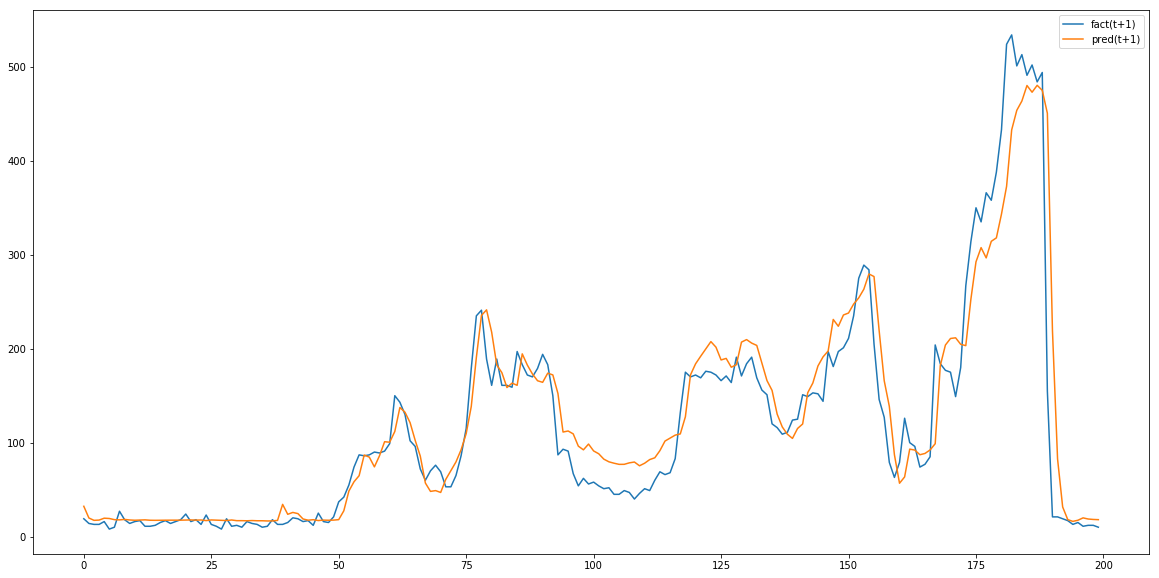

In [38]:
plt.figure(figsize=(20,10))
plt.plot(y_fact.iloc[:,0][:200])
plt.plot(y_pred.iloc[:,0][:200])
plt.legend()
plt.show()

### Long Short-Term Memory Networks

In [39]:
import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.layers import LSTM, LeakyReLU
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import regularizers

output_file_name='Model_LSTM_relu'

units=50
batch_size=72
epochs=50
output_size=3
regb = regularizers.l2(0.01)
regW = regularizers.l2(0.001)

In [40]:
callbacks=[CSVLogger(output_file_name+'.csv', append=True),
                     ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5',
                                     monitor='val_loss', verbose=1,mode='min')]
#EarlyStoppingByLossVal(monitor='val_loss', value=7.93, verbose=1)
#TQDMNotebookCallback()

In [41]:
train_X = train_X.as_matrix().reshape((train_X.shape[0],1,train_X.shape[1]))
test_X = test_X.as_matrix().reshape((test_X.shape[0],1,test_X.shape[1]))

train_Y = train_Y.as_matrix().reshape((train_Y.shape[0], train_Y.shape[1]))
test_Y = test_Y.as_matrix().reshape((test_Y.shape[0], test_Y.shape[1]))

In [43]:
# https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss
    
#Remember - that if you use any kind of regularization - it affects your loss. Your actual loss is equal to:
#loss = mse + regularization
#and this is where your discrepancy comes from.

In [44]:
#build model
model = Sequential()
#model.add(LSTM(units=units, input_shape=(train_X.shape[1], train_X.shape[2]))), input_dim=32, 
#batch_input_shape=(batch_size,1,30), 
model.add(LSTM(units=units, input_dim=33, bias_regularizer=regb, recurrent_regularizer=regW, return_sequences=False))
model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Dense(output_size))
model.add(LeakyReLU())
model.compile(loss='mae', metrics=['mae'], optimizer='adam')
history = model.fit(train_X, train_Y,
          batch_size=batch_size,
          validation_data=(train_X, train_Y),
          epochs = epochs,
          callbacks=callbacks,
                    shuffle=False)

Train on 17512 samples, validate on 17512 samples
Epoch 1/50
17512/17512 [==============================] - 2s 135us/step - loss: 0.4447 - mean_absolute_error: 0.0437 - val_loss: 0.3350 - val_mean_absolute_error: 0.0390
Epoch 2/50
17512/17512 [==============================] - 1s 64us/step - loss: 0.2467 - mean_absolute_error: 0.0224 - val_loss: 0.1914 - val_mean_absolute_error: 0.0292
Epoch 3/50
17512/17512 [==============================] - 1s 74us/step - loss: 0.1397 - mean_absolute_error: 0.0215 - val_loss: 0.1063 - val_mean_absolute_error: 0.0253
Epoch 4/50
17512/17512 [==============================] - 1s 75us/step - loss: 0.0776 - mean_absolute_error: 0.0212 - val_loss: 0.0600 - val_mean_absolute_error: 0.0238
Epoch 5/50
17512/17512 [==============================] - 1s 67us/step - loss: 0.0449 - mean_absolute_error: 0.0211 - val_loss: 0.0374 - val_mean_absolute_error: 0.0233
Epoch 6/50
17512/17512 [==============================] - 1s 62us/step - loss: 0.0297 - mean_absolute_er

Epoch 25/50
17512/17512 [==============================] - 1s 47us/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 26/50
17512/17512 [==============================] - 1s 47us/step - loss: 0.0202 - mean_absolute_error: 0.0201 - val_loss: 0.0226 - val_mean_absolute_error: 0.0225
Epoch 27/50
17512/17512 [==============================] - 1s 47us/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0226 - val_mean_absolute_error: 0.0226
Epoch 28/50
17512/17512 [==============================] - 1s 47us/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0226 - val_mean_absolute_error: 0.0226
Epoch 29/50
17512/17512 [==============================] - 1s 47us/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227
Epoch 30/50
17512/17512 [==============================] - 1s 47us/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0227 - val_mean_abs

17512/17512 [==============================] - 1s 58us/step - loss: 0.0199 - mean_absolute_error: 0.0199 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234
Epoch 50/50
17512/17512 [==============================] - 1s 64us/step - loss: 0.0199 - mean_absolute_error: 0.0199 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234


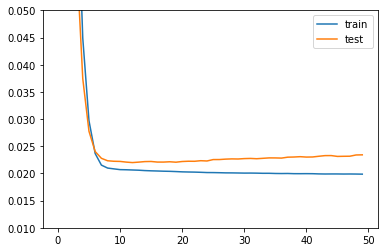

In [45]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim([0.01,0.05])
plt.legend()
plt.show()

In [46]:
y_pred = model.predict(test_X)
y_pred1 = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))

inv_y_pred = scaler_y.inverse_transform(y_pred1)
y_pred = pd.DataFrame(inv_y_pred, columns=["pred(t+1)","pred(t+2)","pred(t+3)"])

y_fact = test_Y.reshape((len(test_Y), n_for))
inv_y_fact = scaler_y.inverse_transform(y_fact)
y_fact = pd.DataFrame(inv_y_fact, columns=["fact(t+1)","fact(t+2)","fact(t+3)"])

In [47]:
for i in range(0,n_for):
    rmse=np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_fact.iloc[:,i]))
    r2=r2_score(y_pred.iloc[:,i], y_fact.iloc[:,i])
    print('Test RMSE: %.3f' % rmse, 'Test R2: %.3f' % r2)

Test RMSE: 27.573 Test R2: 0.911
Test RMSE: 38.165 Test R2: 0.819
Test RMSE: 50.058 Test R2: 0.683


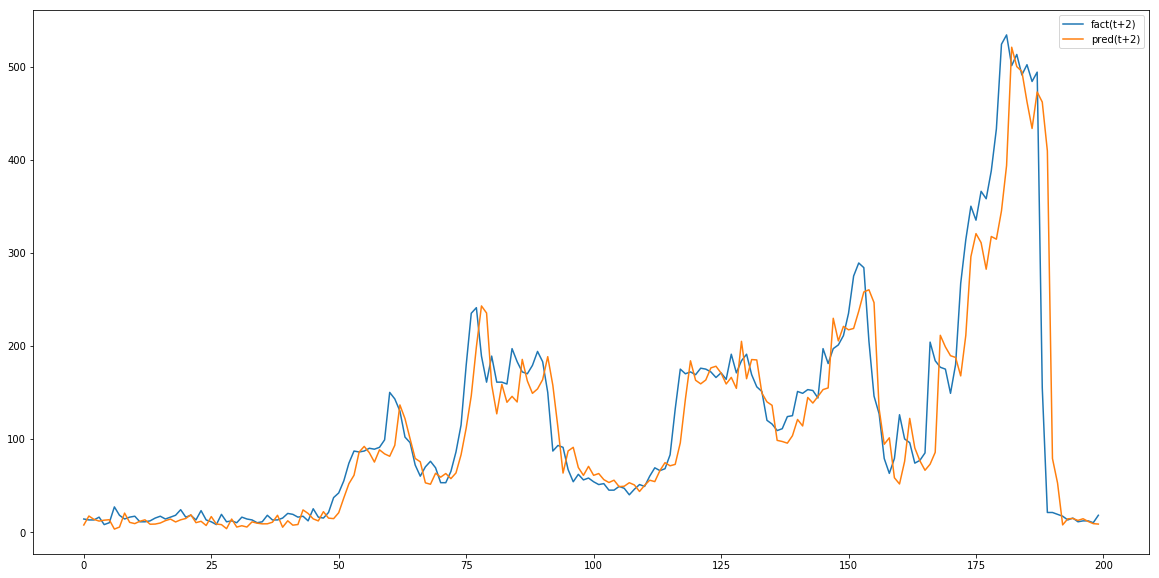

In [48]:
plt.figure(figsize=(20,10))
plt.plot(y_fact.iloc[:,1][:200])
plt.plot(y_pred.iloc[:,1][:200])
plt.legend()
plt.show()

### General Recurrent Unit 

In [49]:
import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras.utils import np_utils
from keras.layers import GRU
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

output_file_name='Model_GRU_relu'

units=50
batch_size=72
epochs=50
output_size=3
regb = regularizers.l2(0.01)
regW = regularizers.l2(0.001)

In [50]:
callbacks=[CSVLogger(output_file_name+'.csv', append=True),
                     ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5',
                                     monitor='val_loss', verbose=1,mode='min')]
#EarlyStoppingByLossVal(monitor='val_loss', value=7.93, verbose=1)
#TQDMNotebookCallback()

In [51]:
#build model
model = Sequential()
model.add(GRU(units=units, input_dim=33,return_sequences=False))
model.add(Activation('tanh'))
#model.add(Dropout(0.2))
model.add(Dense(output_size))
model.add(Activation('relu'))
model.compile(loss='mae', metrics=['mae'], optimizer='adam')
history = model.fit(train_X, train_Y,
          batch_size=batch_size,
          validation_data=(test_X, test_Y),
          epochs = epochs,
          callbacks=callbacks,
                    shuffle=False)

Train on 17512 samples, validate on 26263 samples
Epoch 1/50
17512/17512 [==============================] - 2s 128us/step - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0399 - val_mean_absolute_error: 0.0399
Epoch 2/50
17512/17512 [==============================] - 1s 59us/step - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0260 - val_mean_absolute_error: 0.0260
Epoch 3/50
17512/17512 [==============================] - 1s 62us/step - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214
Epoch 4/50
17512/17512 [==============================] - 1s 61us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206
Epoch 5/50
17512/17512 [==============================] - 1s 57us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202
Epoch 6/50
17512/17512 [==============================] - 1s 61us/step - loss: 0.0216 - mean_absolute_er

17512/17512 [==============================] - 1s 59us/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 26/50
17512/17512 [==============================] - 1s 55us/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 27/50
17512/17512 [==============================] - 1s 59us/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 28/50
17512/17512 [==============================] - 1s 62us/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 29/50
17512/17512 [==============================] - 1s 58us/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 30/50
17512/17512 [==============================] - 1s 58us/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0213 - val_mean_absolute_error:

Epoch 50/50
17512/17512 [==============================] - 1s 59us/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0224 - val_mean_absolute_error: 0.0224


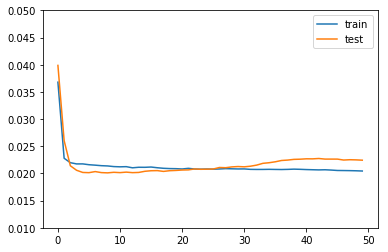

In [52]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim([0.01,0.05])
plt.legend()
plt.show()

In [53]:
y_pred = model.predict(test_X)
y_pred1 = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))

inv_y_pred = scaler_y.inverse_transform(y_pred1)
y_pred = pd.DataFrame(inv_y_pred, columns=["pred(t+1)","pred(t+2)","pred(t+3)"])

y_fact = test_Y.reshape((len(test_Y), n_for))
inv_y_fact = scaler_y.inverse_transform(y_fact)
y_fact = pd.DataFrame(inv_y_fact, columns=["fact(t+1)","fact(t+2)","fact(t+3)"])

In [54]:
for i in range(0,n_for):
    rmse=np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_fact.iloc[:,i]))
    r2=r2_score(y_pred.iloc[:,i], y_fact.iloc[:,i])
    print('Test RMSE: %.3f' % rmse, 'Test R2: %.3f' % r2)

Test RMSE: 25.693 Test R2: 0.916
Test RMSE: 37.926 Test R2: 0.821
Test RMSE: 48.566 Test R2: 0.696


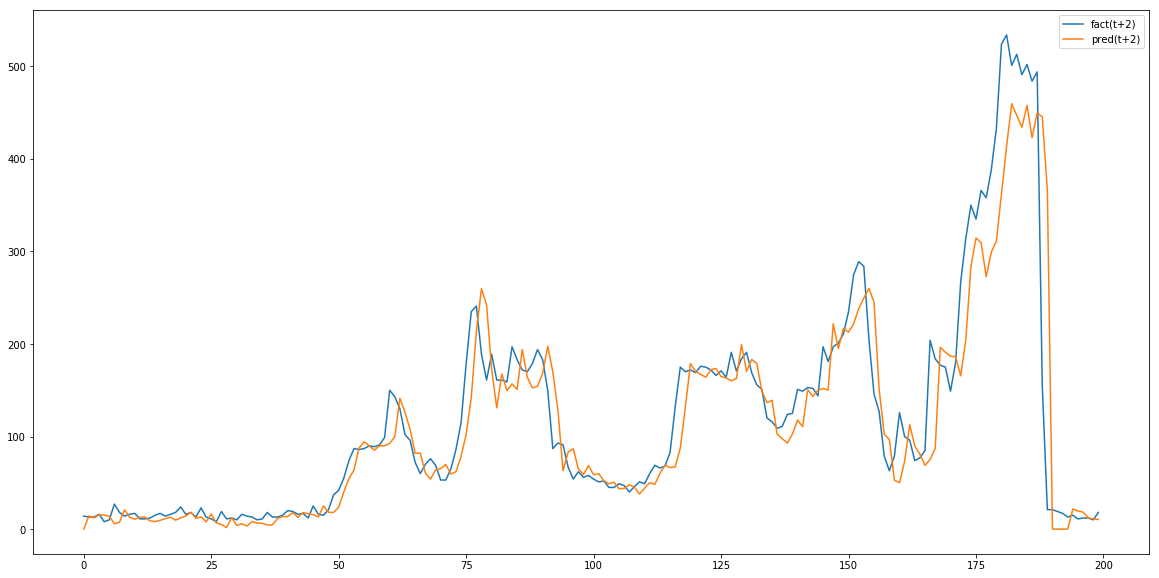

In [55]:
plt.figure(figsize=(20,10))
plt.plot(y_fact.iloc[:,1][:200])
plt.plot(y_pred.iloc[:,1][:200])
plt.legend()
plt.show()